In [13]:
!pip install d2l==1.0.0-beta0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Bây giờ chúng tôi đã sẵn sàng để làm việc thông qua triển khai hồi quy tuyến tính đầy đủ chức năng. Trong phần này, chúng ta sẽ triển khai toàn bộ phương pháp từ đầu, bao gồm 
- (i) mô hình; 
- (ii) hàm mất mát; 
- (iii) trình tối ưu hóa giảm độ dốc ngẫu nhiên minibatch; và 
- (iv) chức năng training kết nối tất cả các phần này lại với nhau.

Cuối cùng, chúng ta sẽ chạy trình tạo dữ liệu tổng hợp từ Phần 3.3 và áp dụng mô hình của chúng tôi trên tập dữ liệu kết quả. Mặc dù các khung học sâu hiện đại có thể tự động hóa gần như tất cả công việc này, nhưng triển khai mọi thứ từ đầu là cách duy nhất để đảm bảo rằng bạn thực sự biết mình đang làm gì. Hơn nữa, khi đến lúc tùy chỉnh các mô hình, xác định các lớp hoặc hàm mất mát của riêng chúng ta, việc hiểu cách mọi thứ hoạt động bí mật sẽ tỏ ra hữu ích. Trong phần này, chúng ta sẽ chỉ dựa vào tenxơ và vi phân tự động. Sau này, chúng tôi sẽ giới thiệu một cách triển khai ngắn gọn hơn, tận dụng lợi thế của các khung học sâu trong khi vẫn giữ nguyên cấu trúc của những gì tiếp theo bên dưới.

In [14]:
# Vẽ biểu đồ trên jupyter notebook
%matplotlib inline            
import torch
from d2l import torch as d2l

**-- GIẢI THÍCH CODE --**

Thêm các thư viên cần dùng: "torch, d2l, matplotlib"

*NOTE*: Việc triển khai lập trình hướng đối tượng cho lập trình hồi quy tuyến tính sử dụng khá nhiều class có sẵn của d2l và đã được giới thiệu ở các phần trước.

# 3.4.1. Xác định mô hình

Trước khi ta có thể bắt đầu tối ưu hóa các tham số của mô hình bằng minibatch SGD, ta cần phải có 1 bộ tham số ngay từ đầu.

Ở phần tiếp theo, ta khởi tạo các trọng số bằng cách lấy các số ngẫu nhiên từ phân phối chuẩn với mean = 0 và std = 0.01. Số sigma = 0.01 thường hoạt động tốt trong thực tế. 

Ngoài ra, ta cx sẽ đặt bias = 0

In [15]:
class LinearRegressionScratch(d2l.Module):
  def __init__(self, num_inputs, lr, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad = True)
    self.b = torch.zeros(1, requires_grad = True)

**-- GIẢI THÍCH CODE --**

Tạo 1 class tượng trưng cho model, và model ở đây là hồi quy tuyến tính, được kế thừa từ class Module trong thư viện d2l (1 thư viện bao gồm những đặc tính chung về model như: "Hàm loss, mạng network, plot, training_step, validation_step, configure_optimizers".

Sau khi kế thừa, ta khởi tạo bộ thông số đầu bao gồm w và b trong model bằng cách:


```
self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad = True)
self.b = torch.zeros(1, requires_grad = True)
```



Tiếp theo ta cần phải xác định mô hình, liên hệ đầu vào và tham số của nó với đầu ra.

In [16]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
  return torch.matmul(X, self.w) + self.b

**-- GIẢI THÍCH CODE --**

Tiếp đến ta cần định nghĩa phương trình hồi quy tuyến tính hay hiểu rộng hơn là mạng nơ-ron cho model.
$$y=wx+b$$

Ở thư viện d2l có hàm `add_to_class` cho phép ta thêm phương thức vào trong class ở ngoài phạm vi của class.

# 3.4.2. Xác định hàm mất mát

Việc cập nhật mô hình của ta yêu cầu lấy độ dốc của hàm mất mát nên đầu tiên phải xác định hàm mất mát.

In [17]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
    l = (y_hat - y)**2 / 2
    return l.mean()

**-- GIẢI THÍCH CODE --**

Kế đến ta định nghĩa hàm mất mát ở trong Model, để `backward` dễ dàng thì ở hàm loss ta trả về `l.mean()` (vì nếu chạy `l.backward()` thì l phải là số vô hướng) 

# 3.4.3. Xác định thuật toán tối ưu

Ở mỗi bước, bằng cách sử dụng một minibatch được rút ngẫu nhiên từ tập dữ liệu, chúng ta ước tính độ dốc của tổn thất đối với các tham số. Tiếp theo, chúng ta cập nhật các tham số theo hướng có thể giảm tổn thất.

In [18]:
class SGD(d2l.HyperParameters):
  def __init__(self, params, lr):
    self.save_hyperparameters()

  def step(self):
    for param in self.params:
      param -= self.lr * param.grad

  def zero_grad(self):
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

**-- GIẢI THÍCH CODE --**

Kế đến, ta khởi tạo class SGD chính là thuật toán tối ưu.

Trong mọi Class đều có dòng code:
```
self.save_hyperparameters()
```
là một phương thức của class `HyperParrameters` trong thư viện cho phép biến các input của hàm khởi tạo thành thuộc tính của class.

Trong class `SGD` có 2 phương thức:
- `step` để update các tham số $(w, b)$.
- `zero_grad` để reset lại gradient về 0 trước khi lan truyền ngược - `backward` vì nếu không sẽ bị cộng dồn => sai.


Tiếp theo, ta định nghĩa phương thức `configure_optimizers`

In [19]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
  return SGD([self.w, self.b], self.lr)

**-- GIẢI THÍCH CODE --**

Tiếp đến, ta cần đẩy thuật toán tối ưu này vào trong Model bằng hàm `add_to_class` của thư viện d2l.

# 3.4.4. Training 

Bây giờ chúng ta đã có tất cả các phần (tham số, hàm mất mát, mô hình và trình tối ưu hóa), chúng ta đã sẵn sàng triển khai vòng lặp training chính. 

Các bước:
*   Khởi tạo bộ tham số  $(w,b)$
*   Lặp lại cho tới khi hoàn thành
    * Tính gradient $\mathbf{g} \leftarrow \partial_{(\mathbf{w},b)} \frac{1}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} l(\mathbf{x}^{(i)}, y^{(i)}, \mathbf{w}, b)$
    * Cập nhật bộ tham số $(\mathbf{w}, b) \leftarrow (\mathbf{w}, b) - \eta \mathbf{g}$




In [20]:
# @d2l.add_to_class(d2l.Trainer)
# def prepare_batch(self, batch):
#   return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
  #self.model.train()
  for batch in self.train_dataloader:
    loss = self.model.training_step(batch)
    self.optim.zero_grad()
    with torch.no_grad():
      loss.backward()
      # if self.gradient_clip_val > 0:  # To be discussed later
      #   self.clip_gradients(self.gradient_clip_val, self.model)
      self.optim.step()
    self.train_batch_idx += 1
  if self.val_dataloader is None:
    return
  #self.model.eval()
  for batch in self.val_dataloader:
    with torch.no_grad():
      self.model.validation_step(self.prepare_batch(batch))
    self.val_batch_idx += 1
    

**-- GIẢI THÍCH CODE --**

Sau khi đã có đầy đủ từ Model, hàm mất mát, thuật toán tối ưu, ta sẽ đi đến bước tiếp theo đó là training.

Thì ở thư viện d2l đã có 1 class `Trainer` dành riêng cho việc này bao gồm 1 số phương thức như: 


*   `prepare_data`: với đầu vào là data - cũng là 1 class của d2l, sẽ chia thành 2 tập dữ liệu, 1 tập để train - `train_dataloader` và 1 tập để kiểm thử - `validation_dataloader`.
*   `prepare_model`: với đầu vào là model để khởi tạo model
*   `fit`: với đầu vào là model và data, ở đây ta sẽ chạy `prepare_data`, `prepare_model`, gán `self.optim` = `model.configure_optimizers()` sau đó khởi tạo 1 vòng for chạy theo số lượng epoch, mỗi vòng ta lại chạy phương thức `fit_epoch`
*   `fit_epoch`: Thực hiện nhiệm vụ fit model với data hay còn gọi là huấn luyện trong mỗi 1 epoch. Đầu tiên là sẽ xét từng batch trong cả tập dữ liệu. 
```
for batch in self.train_dataloader:
```
Tiếp theo là tính toán loss. 
```
loss = self.model.training_step(batch)
```
Như đã đề cập, trước khi lan truyền ngược ta cần reset các giá trị gradient về 0. 
```
self.optim.zero_grad()
```
Sau đó ta thực hiện lan truyền ngược. 
```
loss.backward()
```
Cuối cùng ta thực hiện update tham số $(w, b)$ và đến batch tiếp theo.
```
self.optim.step()
```

Đoạn code cuối:
```
  if self.val_dataloader is None:
    return
  #self.model.eval()
  for batch in self.val_dataloader:
    with torch.no_grad():
      self.model.validation_step(self.prepare_batch(batch))
    self.val_batch_idx += 1
```
Kiểm tra xem có tập dữ liệu kiểm thử không, nố có thì thực hiện `validation_step` để tính loss và vẽ ra đồ thị.

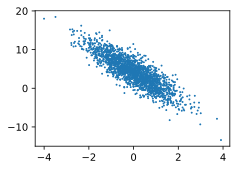

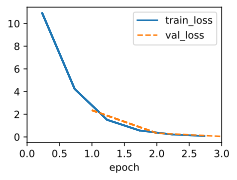

In [23]:
model = LinearRegressionScratch(2, lr=0.03)  
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
features, labels = data.X, data.y
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

**-- GIẢI THÍCH CODE --**
- Đầu tiên, ta khởi tạo mô hình hồi quy tuyến tính với số lượng $w$ và $lr$ mong muốn
```
model = LinearRegressionScratch(2, lr=0.03)  
```
- Khởi tạo tập dữ liệu từ một mô hình hồi quy tuyến tính với $w$ vs $b$ cho trước.
```  
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
```
- Vẽ phân bố của tập dữ liệu
```
features, labels = data.X, data.y
d2l.set_figsize((3.5, 2.5))
d2l.plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);
```
- Khởi tạo `trainer`
```
trainer = d2l.Trainer(max_epochs=3)
```
- Sử dụng `fit` của `trainer` để fit model với data
```
trainer.fit(model, data)
```

In [24]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.1087, -0.1976], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.2036], grad_fn=<RsubBackward1>)


Cuối cùng, ta kiểm tra thử sai số của tham số thật và tham số học được.

# Thắc mắc
1. `torch.no_grad()`
  Theo em hiểu và đọc được thì ở trong context của `with torch.no_grad():` là khi không cần dùng backward để giảm thiểu bộ nhớ và tính toán nhưng ở đây mình lại cho `backward` vào trong context này. Em vẫn chưa hiểu lắm ạ.
2. Tất cả những cmt ở trong code đều là của họ, em đọc thấy không liên quan lắm và có cmt nó đi và chạy thử vẫn chạy đúng, em cũng chưa rõ chủ đích mấy dòng code đó của họ ạ.